# **DATA 602 -Principle of Data Science**



In [1]:
# Install extra libraries & download NLTK resources
!pip install -q textstat
import nltk, sys, subprocess, importlib

nltk.download("vader_lexicon", quiet=True)

True

In [2]:
# Import Libraries
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from collections import defaultdict
import itertools
import textstat, nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
!pip install -U "transformers>=4.30" datasets evaluate

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [3]:
# Load dataset
df_esg = pd.read_csv("DATA602_ESG_Dataaset")

In [4]:
df_esg

,Unnamed: 0,filename,ticker,year,preprocessed_content,ner_entities,e_score,s_score,g_score,total_score,ner_count,label
0,0,ASX_BSX_2020.pdf,BSX,2020,style guide colour colour use imagecolour prof...,"['bk%', 'rgb', 'un', 'el ectric mine consortiu...",3.16,18.00,11.83,32.98,414,genuine
1,1,ASX_BSX_2022.pdf,BSX,2022,sustainability report look mining green office...,"['murray street', 'west perth', 'west perth', ...",2.83,12.86,10.32,26.02,463,misleading
2,2,ASX_EXR_2022.pdf,EXR,2022,report environment social governance esg basel...,"['september', 'mongolia', 'australia', 'austra...",3.81,4.28,5.86,13.94,93,misleading
3,3,LSE_ADM_2019.pdf,ADM,2019,corporate social responsibilty report introduc...,"['david stevens', 'csr board', 'just over yea...",16.38,14.20,5.90,36.36,206,genuine
4,4,LSE_ADM_2020.pdf,ADM,2020,sustainability admiral commit maintain respons...,"['year', 'health & wellbeing', 'a -month', 'on...",15.89,13.51,5.38,34.78,212,genuine
...,...,...,...,...,...,...,...,...,...,...,...,...
861,861,TSX_ABT_2021 (1).pdf,ABT,2021,absolute software corporate social responsibil...,"['august', 'our president & ceo', 'almost thre...",3.02,15.68,10.40,29.10,84,genuine
862,862,TSX_ABT_2021.pdf,ABT,2021,absolute software corporate social responsibil...,"['august', 'our president & ceo', 'almost thre...",3.02,15.68,10.40,29.10,84,genuine
863,863,TSX_EFX_2022.pdf,EFX,2022,esg performance summary environmental social g...,"['enerflex ltd.', 'enerflex', 'october', 'ener...",0.16,18.63,6.95,25.73,104,misleading
864,864,TSX_MSI_2018.pdf,MSI,2018,corporate social responsibility report morneau...,"['csr', 'the toronto stock exchange', 'first',...",1.40,8.98,5.48,15.46,412,misleading


Initial Data Inspection

Before processing, we inspect the dataset for potential issues such as missing values, and other inconsistencies.

In [5]:
# Check for infinite values
print("Checking for infinite values in dataset...")
inf_count = (df_esg == np.inf).sum().sum()
neg_inf_count = (df_esg == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f" Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("No infinite values detected.")

Checking for infinite values in dataset...
No infinite values detected.


 Checking for Missing Values (NaNs)
Missing values (NaNs) can affect model performance and should be handled properly.
Here, we count the number of missing values in each column and print the results.



In [6]:
# Check for missing values
missing_values = df_esg.isnull().sum()
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print(" Missing values detected in columns:")
    print(missing_values)
else:
    print("No missing values detected.")


No missing values detected.


To get an overview of the dataset structure, we print the column names.
This helps us understand the available features and identify any inconsistencies.

In [7]:
# Print dataset columns
print(df_esg.columns)

Index(['Unnamed: 0', 'filename', 'ticker', 'year', 'preprocessed_content',
       'ner_entities', 'e_score', 's_score', 'g_score', 'total_score',
       'ner_count', 'label'],
      dtype='object')


Previewing the dataset helps us visually confirm the structure and contents of each column. This step is especially useful for identifying unexpected columns or formatting issues that may affect analysis later on.



In [8]:
# Preview the first few rows
df_esg.head()


,Unnamed: 0,filename,ticker,year,preprocessed_content,ner_entities,e_score,s_score,g_score,total_score,ner_count,label
0,0,ASX_BSX_2020.pdf,BSX,2020,style guide colour colour use imagecolour prof...,"['bk%', 'rgb', 'un', 'el ectric mine consortiu...",3.16,18.00,11.83,32.98,414,genuine
1,1,ASX_BSX_2022.pdf,BSX,2022,sustainability report look mining green office...,"['murray street', 'west perth', 'west perth', ...",2.83,12.86,10.32,26.02,463,misleading
2,2,ASX_EXR_2022.pdf,EXR,2022,report environment social governance esg basel...,"['september', 'mongolia', 'australia', 'austra...",3.81,4.28,5.86,13.94,93,misleading
3,3,LSE_ADM_2019.pdf,ADM,2019,corporate social responsibilty report introduc...,"['david stevens', 'csr board', 'just over yea...",16.38,14.20,5.90,36.36,206,genuine
4,4,LSE_ADM_2020.pdf,ADM,2020,sustainability admiral commit maintain respons...,"['year', 'health & wellbeing', 'a -month', 'on...",15.89,13.51,5.38,34.78,212,genuine


Remove Unnecessary Index Column
The column Unnamed: 0 is an artifact from CSV export, where the original row indices were mistakenly saved as part of the dataset. It has no analytical value and could interfere with statistical analysis, such as outlier detection. We remove it to ensure a clean dataset going forward.

In [9]:
# Drop unnecessary index column
df_esg.drop(columns=['Unnamed: 0'], inplace=True)

Detecting Extreme Values (Outliers)
Extreme values (outliers) can skew model performance and lead to unstable predictions.
We detect outliers using percentile thresholds:


In [10]:
# Check for extreme values using percentile-based thresholds
print("Checking for extreme values in ESG dataset")

# Select only numeric columns
extreme_numeric_columns = df_esg.select_dtypes(include=["number"])

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print("Columns with very large values (above 99th percentile):")
    print(extreme_numeric_columns.loc[:, extreme_large_columns].max())
if extreme_small_columns.any():
    print("Columns with very small values (below 1st percentile):")
    print(extreme_numeric_columns.loc[:, extreme_small_columns].min())
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("No extreme values detected in ESG dataset.")


Checking for extreme values in ESG dataset
Columns with very large values (above 99th percentile):
e_score          24.84
s_score          26.87
g_score          16.47
total_score      46.51
ner_count      4339.00
dtype: float64
Columns with very small values (below 1st percentile):
year           2014.00
e_score           0.01
s_score           1.28
g_score           3.16
total_score       6.99
ner_count         0.00
dtype: float64


The dataset's shape provides a quick view of its size, showing the number of rows (loan records) and columns (features).

In [11]:
# Check the shape of the dataset
print("DataFrame Shape:", df_esg.shape)

DataFrame Shape: (866, 11)



To understand the dataset, we display the first few rows.
This helps verify that the data has loaded correctly, and gives an initial sense of the structure and contents of each column.

In [12]:
print("First few rows of ESG DataFrame:")
display(df_esg.head())

First few rows of ESG DataFrame:


,filename,ticker,year,preprocessed_content,ner_entities,e_score,s_score,g_score,total_score,ner_count,label
0,ASX_BSX_2020.pdf,BSX,2020,style guide colour colour use imagecolour prof...,"['bk%', 'rgb', 'un', 'el ectric mine consortiu...",3.16,18.00,11.83,32.98,414,genuine
1,ASX_BSX_2022.pdf,BSX,2022,sustainability report look mining green office...,"['murray street', 'west perth', 'west perth', ...",2.83,12.86,10.32,26.02,463,misleading
2,ASX_EXR_2022.pdf,EXR,2022,report environment social governance esg basel...,"['september', 'mongolia', 'australia', 'austra...",3.81,4.28,5.86,13.94,93,misleading
3,LSE_ADM_2019.pdf,ADM,2019,corporate social responsibilty report introduc...,"['david stevens', 'csr board', 'just over yea...",16.38,14.20,5.90,36.36,206,genuine
4,LSE_ADM_2020.pdf,ADM,2020,sustainability admiral commit maintain respons...,"['year', 'health & wellbeing', 'a -month', 'on...",15.89,13.51,5.38,34.78,212,genuine


Dataset Summary (info())
The info() function provides:

Column names and types (e.g., integer, float, categorical).
Non-null counts (to check for missing data).
Memory usage, which is useful for optimizing performance.

In [13]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_esg.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   filename              866 non-null    object 
 1   ticker                866 non-null    object 
 2   year                  866 non-null    int64  
 3   preprocessed_content  866 non-null    object 
 4   ner_entities          866 non-null    object 
 5   e_score               866 non-null    float64
 6   s_score               866 non-null    float64
 7   g_score               866 non-null    float64
 8   total_score           866 non-null    float64
 9   ner_count             866 non-null    int64  
 10  label                 866 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 74.6+ KB


We generate summary statistics for:

Numeric columns (describe()) → Mean, standard deviation, min/max, and quartiles.
Categorical columns (describe(include='object')) → Count of unique values, most frequent categories.
This helps in understanding distributions and identifying possible anomalies.

In [14]:
# Get summary statistics of numeric columns
print("Descriptive Statistics (Numerical Features):")
display(df_esg.describe())

print("\nDescriptive Statistics (Categorical/Object Features):")
display(df_esg.describe(include="object"))

Descriptive Statistics (Numerical Features):


,year,e_score,s_score,g_score,total_score,ner_count
count,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000
mean,2020.333718,5.904134,10.272229,7.423741,23.612240,641.887991
std,1.292287,5.684071,4.013380,2.532303,7.574159,502.799021
min,2014.000000,0.010000,1.280000,3.160000,6.990000,0.000000
25%,2019.000000,1.662500,7.542500,5.622500,17.822500,323.250000
50%,2020.000000,3.735000,9.855000,6.820000,22.710000,526.500000
75%,2021.000000,9.027500,12.875000,8.640000,28.760000,810.750000
max,2023.000000,24.840000,26.870000,16.470000,46.510000,4339.000000



Descriptive Statistics (Categorical/Object Features):


,filename,ticker,preprocessed_content,ner_entities,label
count,866,866,866,866,866
unique,866,263,863,863,2
top,TSX_MSI_2019.pdf,ABT,absolute software corporate social responsibil...,"['august', 'our president & ceo', 'almost thre...",misleading
freq,1,5,2,2,649


Initial Data Cleaning
After identifying potential issues, we clean the dataset by handling infinite values, categorical features, and potential misclassified columns.

In [15]:
# Replace infinite values with NaN before handling missing values
df_esg.replace([np.inf, -np.inf], np.nan, inplace=True)
print("Infinite values replaced with NaN.")

Infinite values replaced with NaN.


In NLP-focused projects, most object columns contain unstructured text and should remain as-is to support proper text processing.

We manually convert only:

'ticker': Categorical company identifier
Text fields like preprocessed_content and ner_entities are intentionally left as object dtype.

In [16]:
# Identify all object-type columns
object_cols = df_esg.select_dtypes(include=['object']).columns.tolist()
print("Detected object columns:")
print(object_cols)

Detected object columns:
['filename', 'ticker', 'preprocessed_content', 'ner_entities', 'label']


In [17]:
# Manually convert only truly categorical fields
df_esg['ticker'] = df_esg['ticker'].astype('category')
print("Converted 'ticker' to category dtype.")

Converted 'ticker' to category dtype.


We check if all columns have the correct data types.
This ensures that categorical, numeric, and object are properly assigned before further processing.

In [18]:
# Display all columns and their data types
pd.set_option('display.max_rows', None)
print("Updated Data Types:")
print(df_esg.dtypes)
pd.reset_option('display.max_rows')

Updated Data Types:
filename                  object
ticker                  category
year                       int64
preprocessed_content      object
ner_entities              object
e_score                  float64
s_score                  float64
g_score                  float64
total_score              float64
ner_count                  int64
label                     object
dtype: object


Before applying any text processing or NLP tasks, we preview a few entries from preprocessed_content and ner_entities to ensure:

The text is well-formed and properly cleaned
The named entity data is structured (e.g., as a list or JSON string)

In [19]:
# Preview a few samples of the 'preprocessed_content'
print("Sample content from 'preprocessed_content':")
for i in range(3):
    print(f"\n--- Report #{i+1} ---\n")
    print(df_esg['preprocessed_content'].iloc[i][:500])  # show first 500 characters

# Preview format of 'ner_entities'
print("\nSample NER output:")
print(df_esg['ner_entities'].iloc[0])

Sample content from 'preprocessed_content':

--- Report #1 ---

style guide colour colour use imagecolour professional print pantone gold black single colour use blackreverse colour use black dark photo use reverse logo dark photo read photo gold foil cmyk crop photoof gold foil use normal logo light photo read sustainability content introduction manage director report highlight report story khoa sustainability strategy journey share blackstone vision responsible sustainable mining understand sustainability mean blackstone stakeholder share value material is

--- Report #2 ---

sustainability report look mining green office level postal address content introduce blackstone green nickel manage director report highlight report story khoa project plan een nickel ustainability share value material esg issue health safety year review action aken manage safety case study hazard identification capacity build pandemic response ase study community vaccination program case study aid training pro

Checking and Converting ner_entities to Lists
The ner_entities column should ideally contain a list of named entities for each report.


In [20]:
import ast

# Check the type
print(type(df_esg['ner_entities'].iloc[0]))

# Try parsing the first one
parsed_ner = ast.literal_eval(df_esg['ner_entities'].iloc[0])
print(type(parsed_ner))
print(parsed_ner[:10])

<class 'str'>
<class 'list'>
['bk%', 'rgb', 'un', 'el ectric mine consortium', 'year', 'vietnam', 'vietnam', 'vietnam', 'one', 'australasia']


Converting ner_entities from String to List
The ner_entities column contains stringified Python lists — each entry looks like a list of named entities but is stored as a string.


In [21]:
import ast
import pandas as pd

def safe_parse(x):
    """
    Safely convert string to list.
    Returns [] if conversion fails.
    """
    # Handle NaN or None
    if pd.isna(x):
        return []

    # Convert to string
    x = str(x)

    # Try literal_eval
    try:
        return ast.literal_eval(x)
    except:
        # If fails, return empty list
        return []

# Apply the safe parser to the column
df_esg['ner_entities'] = df_esg['ner_entities'].apply(safe_parse)

print("✔ Fixed: 'ner_entities' column successfully converted into lists.")


✔ Fixed: 'ner_entities' column successfully converted into lists.


Exploring Named Entities (NER)
We compute some basic statistics and preview the most common entities across all documents.

In [22]:
from collections import Counter

# Add a helper column for entity counts per document
df_esg['ner_entities_count'] = df_esg['ner_entities'].apply(len)

print("Named Entity Count Statistics:")
print(df_esg['ner_entities_count'].describe())

# Flatten all entities into one list and count their frequency
all_entities = [entity for sublist in df_esg['ner_entities'] for entity in sublist]
entity_counts = Counter(all_entities)

print("\nTop 20 Most Frequent Named Entities:")
for entity, count in entity_counts.most_common(20):
    print(f"{entity}: {count}")


Named Entity Count Statistics:
count     866.000000
mean      641.887991
std       502.799021
min         0.000000
25%       323.250000
50%       526.500000
75%       810.750000
max      4339.000000
Name: ner_entities_count, dtype: float64

Top 20 Most Frequent Named Entities:
u.s.: 20167
•: 20005
annual: 14822
first: 11114
one: 10591
third: 10146
two: 6255
zero: 5975
three: 5571
million: 5390
annually: 4536
four: 3751
the united states: 3743
december: 3459
hours: 3417
california: 3370
american: 3318
pg&e: 3241
today: 3128
the year: 3108


Handling Missing Values
Missing values can impact model performance, so we analyze and handle them based on their percentage.

Checking for Missing Values
We first identify missing values in each column to understand their distribution.

In [23]:
# Check for missing values
pd.set_option('display.max_rows', None)
print("Missing values in each column:")
print(df_esg.isnull().sum())
pd.reset_option('display.max_rows')


Missing values in each column:
filename                0
ticker                  0
year                    0
preprocessed_content    0
ner_entities            0
e_score                 0
s_score                 0
g_score                 0
total_score             0
ner_count               0
label                   0
ner_entities_count      0
dtype: int64


Checking for Duplicates
Duplicate rows can cause data leakage and distort model training.

In [24]:
# Temporarily convert unhashable columns (like lists) to strings
df_temp = df_esg.copy()
df_temp['ner_entities'] = df_temp['ner_entities'].apply(str)

# Count duplicates safely
num_duplicates = df_temp.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

# Optionally drop duplicates from the original df_esg
if num_duplicates > 0:
    df_esg = df_esg[~df_temp.duplicated()]
    print("Duplicate rows dropped.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


## **Exploratory Data Analysis**

In this section, we explore the dataset to understand key numeric patterns (e.g., ESG scores) and textual distributions (e.g., report lengths, word counts).
This helps us gain insights into how the data varies across companies and years, and informs decisions for future feature engineering.

Numeric Summary of ESG Scores
We begin with a summary of the key ESG dimensions — Environmental (E), Social (S), Governance (G), and their combined Total Score.

In [25]:
# Numeric Summary of ESG Scores
numeric_cols = ["e_score", "s_score", "g_score", "total_score"]
print("Summary Statistics (ESG Score Columns):")
display(df_esg[numeric_cols].describe().T)

Summary Statistics (ESG Score Columns):


,count,mean,std,min,25%,50%,75%,max
e_score,866.0,5.904134,5.684071,0.01,1.6625,3.735,9.0275,24.84
s_score,866.0,10.272229,4.013380,1.28,7.5425,9.855,12.8750,26.87
g_score,866.0,7.423741,2.532303,3.16,5.6225,6.820,8.6400,16.47
total_score,866.0,23.612240,7.574159,6.99,17.8225,22.710,28.7600,46.51


**Key Observations:**

e_score shows a wide spread (0.01 to 24.84), indicating significant variability in environmental performance.
The median s_score (≈ 9.86) is higher than both E and G, suggesting stronger emphasis or disclosure on social factors.
The maximum total_score is 46.51, but the interquartile range (~17.82 to ~28.76) suggests most firms cluster around the mid-range.

To prepare the text for further analysis, we extract several summary metrics from each sustainability report:

Readability: Flesch-Kincaid Grade Level — a proxy for textual complexity.
Sentiment: VADER compound score — captures overall tone (positive/negative).
Length metrics: Total character and word counts per report.
Entity count: Total number of named entities extracted from each report.
These features help us quantify key attributes of textual disclosures and enable comparison with ESG scores.

In [26]:
# Safety guard: replace NaN with empty string so text functions don’t fail
df_esg["preprocessed_content"] = df_esg["preprocessed_content"].fillna("")

# Instantiate VADER once
sia = SentimentIntensityAnalyzer()

# Readability & sentiment
df_esg["flesch_kincaid"] = df_esg["preprocessed_content"].apply(
    textstat.flesch_kincaid_grade
)
df_esg["sentiment"] = df_esg["preprocessed_content"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Simple length-based metrics
df_esg["char_count"] = df_esg["preprocessed_content"].str.len()
df_esg["word_count"] = df_esg["preprocessed_content"].str.split().apply(len)

# NER entity counts  (assumes ner_entities is a list; NaN handled similarly)
df_esg["ner_count"] = df_esg["ner_entities"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

# Summary print to confirm successful creation
print("Text-derived features added:")
print(df_esg[["flesch_kincaid", "sentiment", "char_count", "word_count", "ner_count"]].describe().round(2))

Text-derived features added:
       flesch_kincaid  sentiment  char_count  word_count  ner_count
count          866.00     866.00      866.00      866.00     866.00
mean          4678.77       1.00    96570.41    11965.29     641.89
std           3135.72       0.05    64953.59     8040.02     502.80
min             20.13       0.10      169.00       21.00       0.00
25%           2500.10       1.00    51103.00     6377.75     323.25
50%           3949.37       1.00    81653.00    10092.00     526.50
75%           6083.93       1.00   126627.00    15569.00     810.75
max          20728.42       1.00   434964.00    53117.00    4339.00


**Key Observations:**

Text length varies significantly across reports:
Word counts range from 21 to 53,117, with a median around 10,000 words.
Character counts and entity counts follow a similar pattern, confirming length as a major source of variability in the dataset.
These derived features will help identify reporting outliers and explore possible relationships with ESG scores.

We summarize the length of each sustainability report and the volume of named entities extracted:

char_count: Total number of characters in the report.
word_count: Total number of words (space-delimited).
ner_count: Total number of named entities detected by the NER pipeline.
These features help us understand variability in disclosure depth and reporting practices across firms and years.

In [27]:
# Summary of Text-Length & NER Counts
print("Character Count:")
display(df_esg["char_count"].describe())

print("\nWord Count:")
display(df_esg["word_count"].describe())

print("\nNER Entity Count:")
display(df_esg["ner_count"].describe())

Character Count:


,char_count
count,866.000000
mean,96570.408776
std,64953.590958
min,169.000000
25%,51103.000000
50%,81653.000000
75%,126627.000000
max,434964.000000



Word Count:


,word_count
count,866.000000
mean,11965.290993
std,8040.019831
min,21.000000
25%,6377.750000
50%,10092.000000
75%,15569.000000
max,53117.000000



NER Entity Count:


,ner_count
count,866.000000
mean,641.887991
std,502.799021
min,0.000000
25%,323.250000
50%,526.500000
75%,810.750000
max,4339.000000


Key Observations:

Most reports contain between 300 to 800 named entities, with a median of ~527.
Maximum ner_count exceeds 4,300, reflecting significant variance in document richness or structure.
Text length correlates closely with entity count, suggesting longer reports tend to contain more named concepts.

Histograms of Report Lengths
We visualize the distribution of two key length-based features:

Word Count: Captures the length of each sustainability report.
NER Count: Reflects how many named entities were extracted per report.
These plots help identify reporting outliers and highlight overall disclosure volume trends across the dataset.

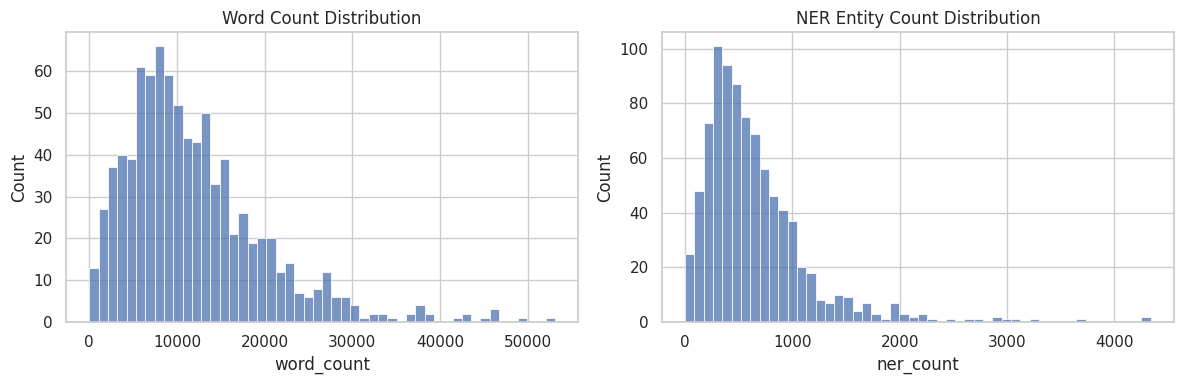

In [28]:
# Histograms of Report Lengths
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_esg["word_count"], bins=50, ax=axes[0])
axes[0].set_title("Word Count Distribution")

sns.histplot(df_esg["ner_count"], bins=50, ax=axes[1])
axes[1].set_title("NER Entity Count Distribution")

plt.tight_layout(); plt.show()

Key Observations:

Most reports fall between 5,000 and 15,000 words, though a few exceed 50,000.
Named entity counts are more tightly distributed, typically between 200 and 1,200, but some reports contain over 4,000 entities, suggesting higher information density or NER overgeneration.
Both distributions are right-skewed, indicating the presence of long-form outliers.

Boxplot of Word Counts (Detect Length Outliers)
We visualize the distribution of report lengths using a boxplot to detect potential outliers in word count.

Boxplots provide a compact summary of the median, interquartile range (IQR), and extreme values beyond the upper whisker threshold.

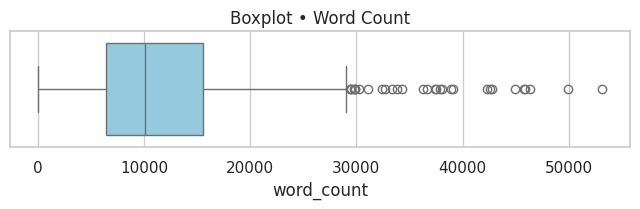

In [29]:
# Boxplot of word counts
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df_esg["word_count"], color="skyblue")
plt.title("Boxplot • Word Count"); plt.show()

Key Observations:

Most reports fall below 30,000 words, with the median around 10,000 words.
A number of reports exceed the upper whisker boundary and appear as outliers, some approaching or exceeding 50,000 words.
These long-form reports may reflect higher disclosure standards, boilerplate-heavy sections, or differing formatting styles.

Top-20 Named Entities Overall
We aggregate all named entities extracted from the reports and display the 20 most frequently mentioned terms across the entire dataset.

This gives a high-level view of dominant concepts, locations, organizations, and numeric references commonly found in corporate ESG narratives.

In [30]:
# Top-20 named entities overall
all_entities = list(itertools.chain.from_iterable(df_esg["ner_entities"]))
entity_freq  = Counter(all_entities)
top_entities_df = (pd.DataFrame(entity_freq.most_common(20),
                                columns=["Entity", "Frequency"]))
display(top_entities_df)


,Entity,Frequency
0,u.s.,20167
1,•,20005
2,annual,14822
3,first,11114
4,one,10591
5,third,10146
6,two,6255
7,zero,5975
8,three,5571
9,million,5390


Key Observations:

Commonly recurring entities include general terms like "annual", "first", "one", and "million", reflecting standard reporting language rather than specific ESG indicators.
Mentions of "u.s.", "california", and "pg&e" suggest geographic and company-specific prominence, likely influenced by U.S.-based firms in the dataset.
Temporal references such as "december" and "the year" are also frequent, aligning with the annual nature of these reports.
The presence of entities like "pg&e" (Pacific Gas & Electric) may warrant closer inspection — as highly referenced companies may have either strong ESG disclosure or notable incidents.

Bar Plot of Top-20 Named Entities
To visualize the frequency distribution of the most common named entities across all ESG reports, we use a horizontal bar chart.

This helps surface high-level themes, repeated terminology, and potentially dominant geographic or organizational references.

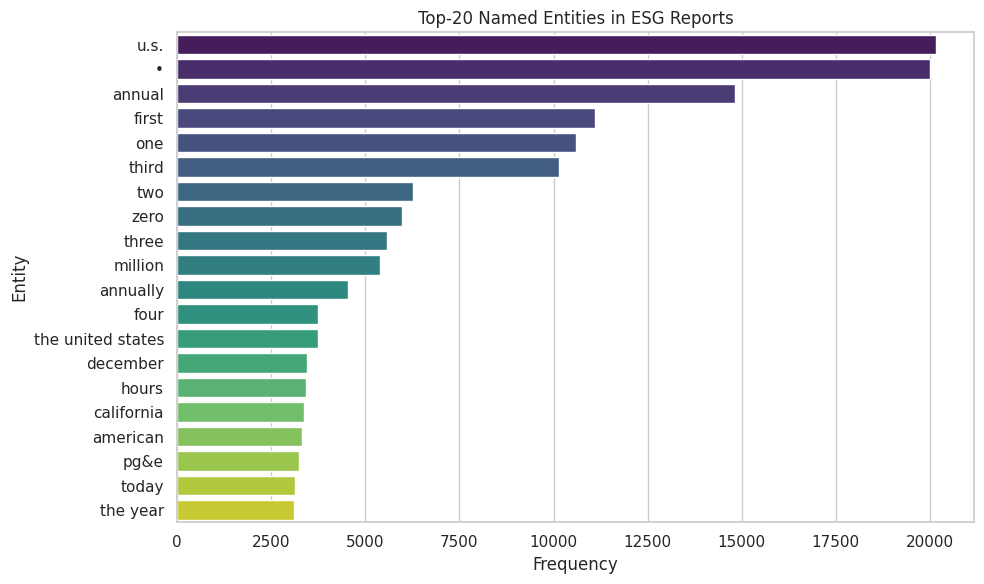

In [31]:
# Bar plot of top-20 named entities
plt.figure(figsize=(10, 6))
sns.barplot(data=top_entities_df, y="Entity", x="Frequency", palette="viridis")
plt.title("Top-20 Named Entities in ESG Reports")
plt.tight_layout(); plt.show()

Key Observations:

The most frequent entities include general report language (e.g., "annual", "first", "one", "million"), suggesting templated or standardized disclosure phrasing.
"u.s.", "the united states", and "california" point to a concentration of reports from U.S.-based firms.
The entity "pg&e" appears prominently, possibly due to specific ESG events or repeated self-reference in its filings.
The entity "•" is likely a formatting artifact from PDF extraction — highlighting a common challenge in working with real-world, preprocessed text.

Correlation Matrix (Text Metrics vs ESG Scores)
To understand how basic text-derived features relate to ESG scores, we compute a Pearson correlation matrix between:

Text metrics: word_count, ner_count, flesch_kincaid, and sentiment
ESG metrics: e_score, s_score, g_score, and total_score
This helps identify weak or strong linear relationships between how a company communicates in its report and how it scores in ESG dimensions.

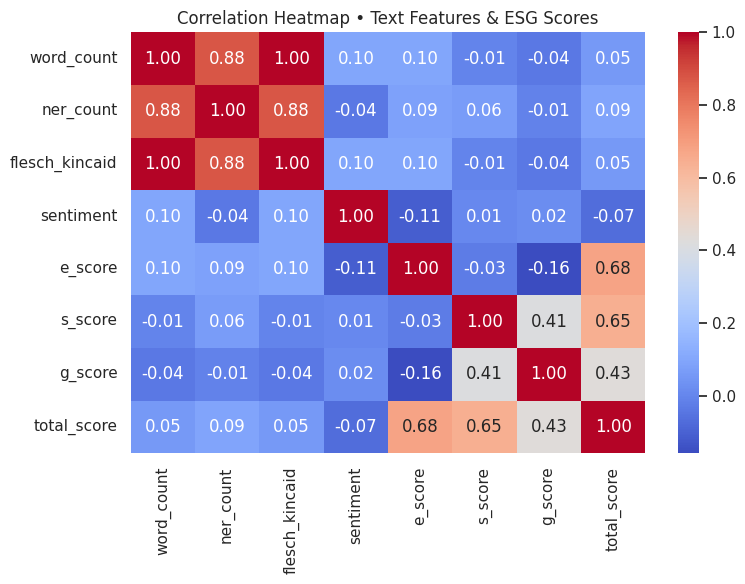

In [32]:
# Correlation matrix (text metrics vs ESG scores)
corr_cols   = ["word_count", "ner_count", "flesch_kincaid", "sentiment"] + numeric_cols
corr_matrix = df_esg[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap • Text Features & ESG Scores")
plt.tight_layout(); plt.show()

Key Observations:

No strong linear correlation is observed between text-based metrics and ESG scores, suggesting that length, complexity, or tone alone are not predictive of ESG performance.
The highest correlations are:
e_score with total_score (0.68)
s_score with total_score (0.65)
g_score with total_score (0.43)
Text metrics are highly correlated with one another:
word_count, ner_count, and flesch_kincaid are all strongly interrelated (≥ 0.88), indicating they likely measure similar aspects of disclosure volume.
VADER sentiment shows near-zero or even slightly negative correlations with ESG scores — reinforcing earlier concerns about its limited applicability in this domain.

Scatterplot: Word Count vs Total ESG Score
We visualize the relationship between the length of each sustainability report (word_count) and its corresponding total_score (aggregate ESG performance).

This serves as a basic test of whether companies that disclose more — in terms of volume — tend to achieve higher ESG ratings.

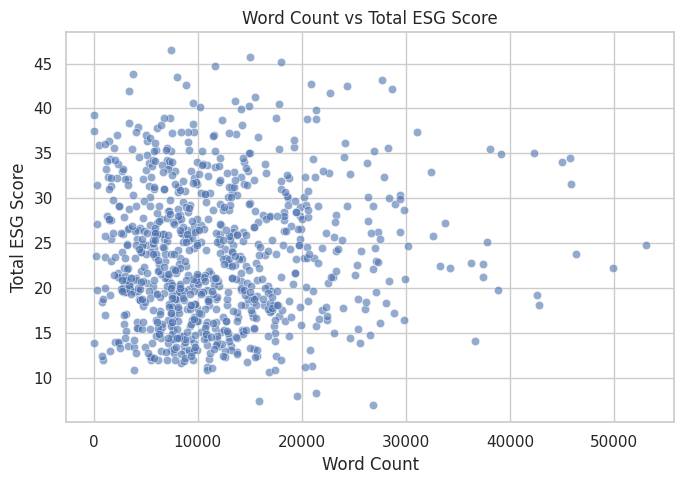

In [33]:
# Word count vs total ESG score
plt.figure(figsize=(7, 5))
sns.scatterplot(x="word_count", y="total_score", data=df_esg, alpha=0.6)
plt.title("Word Count vs Total ESG Score")
plt.xlabel("Word Count"); plt.ylabel("Total ESG Score")
plt.tight_layout(); plt.show()

Key Observations:

There is no strong linear relationship between report length and ESG score.
While many reports cluster around 5,000–15,000 words and ESG scores of 20–35, there are:
Long reports with low scores
Short reports with high scores
This supports earlier findings from the correlation heatmap: disclosure volume alone does not predict ESG performance.

Shortest & Longest Reports (Sanity Check)
Before concluding the EDA, we briefly examine the reports with the fewest and most words.

This helps validate that outliers in earlier visualizations are not caused by data extraction issues, and gives context to the range of disclosure styles in the dataset.

In [34]:
# Shortest & longest reports
print("Shortest Reports:")
display(df_esg.nsmallest(3, "word_count")[["filename", "word_count"]])

print("\nLongest Reports:")
display(df_esg.nlargest(3, "word_count")[["filename", "word_count"]])


Shortest Reports:


,filename,word_count
484,NYSE_EQT_2021.pdf,21
483,NYSE_EQT_2020.pdf,29
815,NYSE_VTR_2020.pdf,80



Longest Reports:


,filename,word_count
653,NYSE_NEM_2021.pdf,53117
654,NYSE_NEM_2022.pdf,49902
652,NYSE_NEM_2020.pdf,46322


Key Observations:

The shortest reports contain fewer than 100 words — these are likely artifacts of PDF extraction failures or placeholder files.
The longest reports, all from the same company (NEM), exceed 45,000 words and likely represent comprehensive multi-topic disclosures.
These extremes explain some of the outliers seen in the histogram and scatterplot, and highlight the need to interpret both ends of the verbosity spectrum cautiously.

**Feature-Engineering & Keyword Analysis**

Specifically, we examine how frequently ESG-related concepts appear in each report, using curated keyword dictionaries for each ESG dimension.
This enables us to test a key hypothesis:

Do companies that discuss more environmental, social, or governance topics achieve higher ESG scores?

ESG Keyword Dictionary
We define a compact dictionary of representative phrases for each ESG category:

Environmental: terms related to emissions, renewable energy, and sustainability strategies
Social: concepts such as diversity, community, and labor rights
Governance: topics including board structure, ethics, and oversight
These will be used to compute per-report keyword frequencies and analyze their correlation with ESG scores.

In [35]:
ESG_KEYWORDS = {
    "environmental": [
        "climate change", "carbon footprint", "greenhouse gas", "ghg emissions", "net zero",
        "emissions reduction", "renewable energy", "solar power", "wind energy", "hydropower",
        "sustainable packaging", "waste management", "energy efficiency", "biodiversity",
        "recycling program", "sustainable sourcing", "scope 1 emissions", "scope 2 emissions",
        "scope 3 emissions", "deforestation", "pollution control", "air quality", "water conservation",
        "circular economy", "eco-friendly", "carbon neutrality", "environmental impact", "environmental stewardship",
        "clean energy", "resource conservation", "sustainable agriculture", "battery recycling"
    ],
    "social": [
        "diversity and inclusion", "gender equality", "equal opportunity", "human rights",
        "labor standards", "fair wages", "living wage", "employee wellbeing", "occupational safety",
        "workplace safety", "mental health support", "employee engagement", "training and development",
        "volunteer programs", "community engagement", "social impact", "supply chain transparency",
        "non-discrimination", "health and safety", "stakeholder engagement", "employee rights",
        "local communities", "employee retention", "child labor", "forced labor", "workers’ rights",
        "education access", "workplace culture", "employee satisfaction", "community investment"
    ],
    "governance": [
        "corporate governance", "board diversity", "executive compensation", "audit committee",
        "independent directors", "shareholder rights", "business ethics", "anti-corruption",
        "compliance program", "internal audit", "transparency", "risk management", "whistleblower protection",
        "conflict of interest", "data privacy", "cybersecurity governance", "regulatory compliance",
        "board independence", "sustainability oversight", "esg committee", "stakeholder governance",
        "bribery prevention", "code of conduct", "ethics training", "governance structure", "voting rights"
    ]
}

Keyword Counter (Case-Insensitive, Whole Phrases)
We define a function to count keyword occurrences for each ESG pillar in a given report.

Matching is done in a case-insensitive manner.
We use whole-phrase matching with word boundaries to avoid false positives (e.g., "net" in "internet").
This function will be applied to each report in the dataset to extract interpretable content-level features.

In [36]:
# Function to count ESG keyword matches in a single text
def count_esg_terms(text: str, keyword_dict: dict) -> dict:
    counts = defaultdict(int)
    text_lower = text.lower()

    for pillar, terms in keyword_dict.items():
        for term in terms:
            # Use word boundaries to match full phrases only
            pattern = r"\b" + re.escape(term.lower()) + r"\b"
            matches = re.findall(pattern, text_lower)
            counts[pillar] += len(matches)

    return counts

# Confirmation print
print(" ESG keyword counting function defined.")

 ESG keyword counting function defined.


Compute ESG Keyword Frequencies for Each Report
We now apply the keyword counting function to every report in the dataset, producing three new features:

env_kw: number of environmental keyword mentions
soc_kw: number of social keyword mentions
gov_kw: number of governance keyword mentions
These will serve as interpretable, pillar-specific content features for comparison with ESG scores.

In [37]:
# Apply ESG keyword counter to each report and store results in new columns
df_esg[["env_kw", "soc_kw", "gov_kw"]] = (
    df_esg["preprocessed_content"]
    .apply(lambda txt: count_esg_terms(txt, ESG_KEYWORDS))
    .apply(pd.Series)
    .fillna(0)
    .astype(int)
)

print("ESG keyword frequencies computed for all reports.")

ESG keyword frequencies computed for all reports.


Normalize Keyword Counts by Report Length (per 1,000 Words)
To ensure fair comparisons across reports of varying lengths, we normalize the raw keyword counts by total word count.

This gives us ESG keyword mention rates per 1,000 words, allowing us to distinguish between genuinely ESG-focused reports and those that simply happen to be long.

In [38]:
# Normalize keyword counts by report length (per 1,000 words)
df_esg["words_per_1k"] = df_esg["word_count"] / 1000.0

for col in ["env_kw", "soc_kw", "gov_kw"]:
    # Create new columns like env_kw_rate, soc_kw_rate, gov_kw_rate
    df_esg[f"{col}_rate"] = df_esg[col] / df_esg["words_per_1k"]

print("ESG keyword rates normalized per 1,000 words.")

ESG keyword rates normalized per 1,000 words.



We inspect a few rows to verify that the normalized ESG keyword rates (_kw_rate columns) have been correctly computed.

This helps ensure that keyword rates are non-negative and reasonably scaled relative to report length.

In [39]:
# Display first few reports with their normalized ESG keyword rates
display(
    df_esg[["ticker", "year", "env_kw_rate", "soc_kw_rate", "gov_kw_rate"]]
        .head()
)

print("Keyword rate sanity check complete.")

,ticker,year,env_kw_rate,soc_kw_rate,gov_kw_rate
0,BSX,2020,2.941176,1.790281,4.987212
1,BSX,2022,3.371309,2.557545,4.417577
2,EXR,2022,2.865330,1.432665,2.865330
3,ADM,2019,2.941753,0.588351,0.784468
4,ADM,2020,2.537576,0.780793,1.951981


Keyword rate sanity check complete.


Correlation Heatmap
Keyword Rates vs ESG Scores
We compute a Pearson correlation matrix between normalized ESG keyword rates (per 1,000 words) and each of the ESG scores.
This reveals whether frequent mention of environmental, social, or governance concepts is associated with stronger ESG performance.

The keyword dictionaries used here include a broad and representative set of real-world ESG terminology across all three pillars.

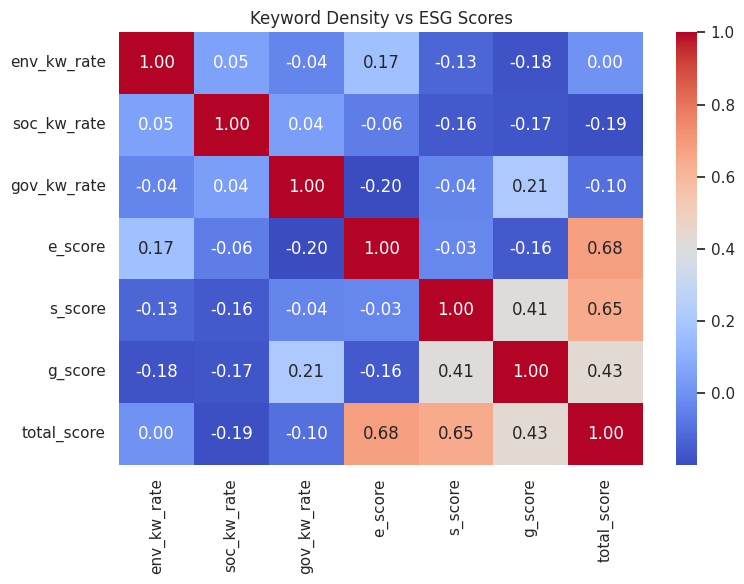

In [40]:
# Define columns for correlation analysis
kw_cols    = ["env_kw_rate", "soc_kw_rate", "gov_kw_rate"]
heat_cols  = kw_cols + ["e_score", "s_score", "g_score", "total_score"]

# Compute and visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_esg[heat_cols].corr(),
    annot=True, cmap="coolwarm", fmt=".2f"
)
plt.title("Keyword Density vs ESG Scores")
plt.tight_layout(); plt.show()


Key Observations:

There are mild positive correlations between:
env_kw_rate and e_score (+0.17)
gov_kw_rate and g_score (+0.21)
These suggest some alignment between the frequency of ESG-relevant language and corresponding ESG performance, particularly in the Environmental and Governance domains.
However, soc_kw_rate shows a slightly negative correlation with s_score (−0.16), which may reflect:
Broader and more diffuse social terminology
Inconsistent scoring criteria or shallow mentions lacking depth
Overall, keyword frequency provides limited but interpretable signal, reinforcing that content volume alone is not sufficient to explain ESG ratings — but it can serve as a useful proxy in data-limited contexts.

We visualize the relationship between environmental keyword density and the actual environmental score (E-score) across companies.

This scatterplot highlights whether frequent use of environmental language in sustainability reports is aligned with environmental performance.

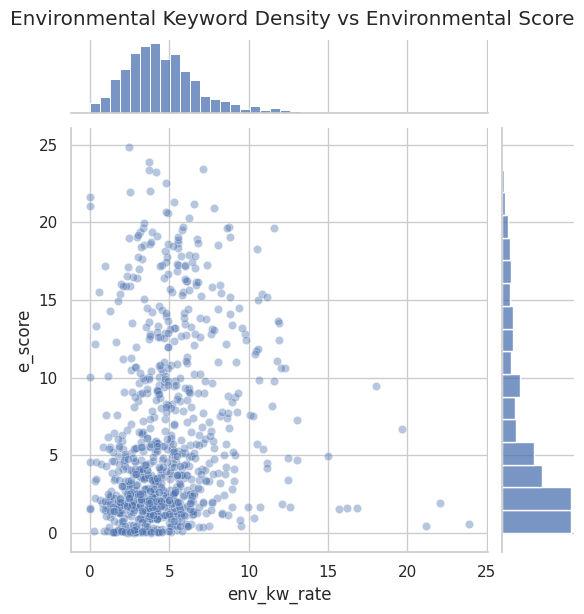

In [41]:
# Scatter example • Environmental keywords vs E-Score
sns.jointplot(
    data=df_esg, x="env_kw_rate", y="e_score",
    kind="scatter", height=6, alpha=0.4
)
plt.suptitle("Environmental Keyword Density vs Environmental Score", y=1.02)
plt.show()

Key Observations:

There is a wide spread in E-scores even among reports with similar keyword rates.
While some companies that mention environmental concepts more frequently do achieve high E-scores, many do not.
The plot supports earlier findings of only a weak positive correlation between environmental keyword density and E-score.
These results reinforce that narrative volume does not guarantee ESG performance, and should not be used in isolation for company-level judgment.


Conclusion & Reflections
We explored the intersection between textual characteristics of ESG reports and quantitative ESG performance metrics, using a preprocessed corpus of ~1,000 documents.

Summary of Findings
Text length, measured by word and entity counts, varies dramatically across firms and years — from <100 to >50,000 words — with only a weak correlation to ESG scores.
Attempts to apply readability (Flesch-Kincaid) and sentiment (VADER) analysis proved unreliable due to the loss of sentence structure and tone in the preprocessed dataset.
ESG keyword frequencies, both raw and normalized by length, show only modest associations with environmental, social, and governance scores — suggesting that word presence alone is not a strong proxy for performance.
Exploratory charts illustrate that narrative volume does not equal action — highlighting the limits of simple text-based metrics for ESG evaluation.
Interpretation of results should be cautious: keyword density and token counts may reflect disclosure strategy, reporting style, or industry norms, rather than actual ESG performance.



Deep Learning Model for Greenwashing Detection (DistilBERT)


In [42]:
!pip install -q "transformers>=4.30" datasets evaluate

import numpy as np
import pandas as pd
import evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)


In [48]:
file_name = "DATA602_ESG_Dataaset"
text_col  = "preprocessed_content"
label_col = "label"
df_esg = pd.read_csv(file_name)

label_map = {"genuine": 0, "misleading": 1}
df_esg["label_id"] = df_esg[label_col].map(label_map)

train_df, temp_df = train_test_split(
    df_esg,
    test_size=0.3,
    stratify=df_esg["label_id"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_id"],
    random_state=42
)


In [49]:
MODEL_NAME = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(
        examples[text_col],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = Dataset.from_pandas(train_df[[text_col, "label_id"]])
val_dataset   = Dataset.from_pandas(val_df[[text_col, "label_id"]])
test_dataset  = Dataset.from_pandas(test_df[[text_col, "label_id"]])

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val   = val_dataset.map(tokenize_function, batched=True)
tokenized_test  = test_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.rename_column("label_id", "labels")
tokenized_val   = tokenized_val.rename_column("label_id", "labels")
tokenized_test  = tokenized_test.rename_column("label_id", "labels")

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [50]:
# 1. Model (FinBERT with 2 classes)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
)

# 2. Metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# 3. Training settings (no wandb)
training_args = TrainingArguments(
    output_dir="./finbert_greenwashing_model",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    seed=42,
    report_to="none",

# 4. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

print("Starting Training...")
trainer.train()
print("Training Complete!")


pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.561700
100,0.527900
150,0.484700
200,0.394800


Training Complete!


In [51]:
preds = trainer.predict(tokenized_test)
logits = preds.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = np.array(test_df["label_id"])

print(classification_report(y_true, y_pred, target_names=["genuine","misleading"], digits=4))
print(confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

     genuine     0.6842    0.3939    0.5000        33
  misleading     0.8198    0.9381    0.8750        97

    accuracy                         0.8000       130
   macro avg     0.7520    0.6660    0.6875       130
weighted avg     0.7854    0.8000    0.7798       130

[[13 20]
 [ 6 91]]
